# implied counts

Adjust counts for time lags and unconfirmed cases.

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

Autosave disabled


In [2]:
from pathlib import Path
from numpy.random import randint
from pandas import DataFrame, Series, date_range, read_csv

In [3]:
FIGSIZE = (9, 5)
FOLDER = Path('../data/rivm').resolve()

## realized counts

Load examples from [CoronaWatchNL] via jonathandebruinos@gmail.com.

[CoronaWatchNL]: https://github.com/J535D165/CoronaWatchNL

In [4]:
def read(name, **kwargs):
    kwargs.setdefault('parse_dates', ['Datum'])
    kwargs.setdefault('index_col', 'Datum')
    return read_csv(FOLDER / name, **kwargs).pop('Aantal')

real = (
    DataFrame()
    .assign(confirmed = read('confirmed.csv'))
    .assign(deceased = read('deceased.csv'))
    .assign(hospitalized = read('hospitalized.csv'))
    .resample('D').sum().astype(int)
    .rename_axis(None)
)
real[::5]

,confirmed,deceased,hospitalized
2020-02-27,1,0,0
2020-03-03,24,0,0
2020-03-08,265,3,0
2020-03-13,804,10,115
2020-03-18,2051,58,408
2020-03-23,4749,213,1230
2020-03-28,9762,639,2954


## implied exposures

Assumptions:

- False-positive rate P(confirmed | not exposed) = 0.
- Confirmation rate P(confirmed | exposed) = `cprob`.
- Confirmations occur `ctime` days after exposure.

**Caution:** If testing is common, then ignoring false positives leads to the [prosecutor's fallacy].

[prosecutor's fallacy]: https://en.wikipedia.org/wiki/Prosecutor's_fallacy

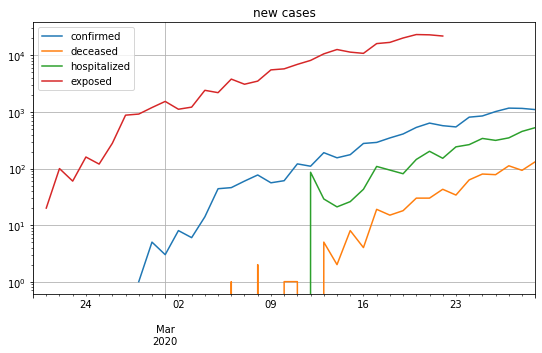

In [5]:
cprob = 0.05
ctime = 7

exposed = (
    real['confirmed'].rename('exposed')
    .div(cprob).shift(-ctime, freq=real.index.freq)
)
data = real.join(exposed, how='outer').diff()
axes = data.plot(figsize=FIGSIZE, grid=True, logy=True, title='new cases')

## implied fatality rates

Assumptions:

- Unconfirmed cases are never fatal.
- Deaths occur `dtime` days after exposure.

**Caution:** P(deceased | exposed) may be much less than [case fatality rate].

[case fatality rate]: https://en.wikipedia.org/wiki/Case_fatality_rate

0.546 deaths per confirmed case
0.12 deaths per implied exposure


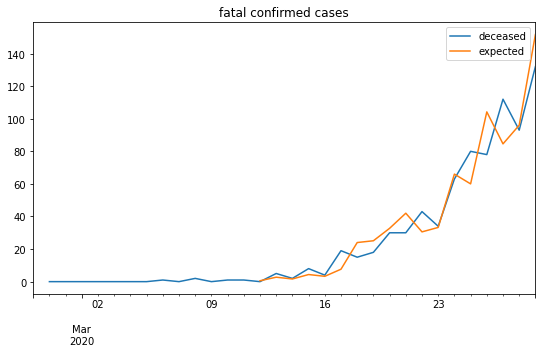

In [6]:
dtime = ctime + 13

confirmed = real['confirmed']
deceased = real['deceased']

cfr = deceased[-1] / confirmed.iat[-(1 + dtime - ctime)]
ifr = deceased[-1] / exposed.iat[-(1 + dtime)]
print(f"{cfr.round(3)} deaths per confirmed case")
print(f"{ifr.round(3)} deaths per implied exposure")

data = DataFrame(deceased.diff())
data['expected'] = cfr * confirmed.diff().shift(dtime - ctime)
axes = data.plot(figsize=FIGSIZE, title='fatal confirmed cases')